# <center>Как найти стог сена в иголке?</center>

## <center>Практический проект по построению системы поиска аномалий.</center>

### Content
* [Подготовка к работе](#preload)
* [Немного теории](#theory)
* [EDA](#eda)
* [Простейшие алгоритмы](#simple_models)
  * [3-сигмы](#3-sigma)
  * [Межквартильное отклонение](#quant)
* [Кластеризация](#cluster)
  * [Distance-based](#cluster_distance)
  * [Density-based: DBSCAN](#cluster_dbscan)
  * [One-Class SVM](#cluster_svm)
  * [Isolation Forest](#isof)
* [Оценка результатов](#summary)

## <center>Подготовка к работе <a class="anchor" id="preload"/></center>

In [75]:
# preload local libs
import sys
import os
import pathlib

project_dir = str(pathlib.Path(os.getcwd()).parent.resolve())
if project_dir not in sys.path:
    sys.path.insert(1, project_dir)

# project_dir

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import yeojohnson
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

import kagglehub

from lib import utils

import warnings

warnings.filterwarnings("ignore")

In [77]:
dataset_dir = project_dir + '/datasets/mlg-ulb/creditcardfraud'

In [78]:
# # Копирование данных из Kaggle в локальный каталог. Делается один раз
# import shutil

# path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
# # print("Path to dataset files:", path)

# shutil.rmtree(dataset_dir, True)
# shutil.copytree(path, dataset_dir)
# shutil.rmtree(path)

In [79]:
df_src = pd.read_csv(dataset_dir + "/creditcard.csv", delimiter=",")

df = df_src.copy()

## <center>Немного теории <a class="anchor" id="theory"/></center>

Есть два больших лагеря задач в обнаружении аномалий — поиск выбросов (outlier detection) и поиск новизны (novelty detection).

#### Поиск выбросов (Outlier Detection)

Это когда есть данные, и среди них уже лежат аномалии, пусть даже редко. Цель — найти странные точки среди того, что тебе дали.

Особенности:

* Модель обучается **на смешанных данных** (нормальные + выбросы).
* Выбросы уже присутствуют в обучающей выборке.
* Чаще всего **не знаем разметку** (что нормально, а что нет).
* Методы стараются понять общую структуру и найти всё, что «выпирает».

Подходит для задач:

* Финансовые транзакции, в которых могут быть редкие мошеннические операции.
* Датчик, иногда выдающий мусорные значения.
* Алгоритмы кластеризации и плотности.

Типичные методы:

* Isolation Forest
* LOF (Local Outlier Factor)
* DBSCAN (точки-шум)
* Статистические методы (Z-score, IQR)

Эти методы спокойно допускают, что в данных уже есть грязь.

#### Поиск новизны (Novelty Detection)

Обучение происходит на нормальных данных, а потом пытаемся понять, что появившаяся новая точка — не из этого мира.

Особенности:

* Обучение **только на нормальных примерах**
* Модель строит «фронтир» нормального поведения.
* Всё, что снаружи этой области — новинка (аномалия).
* Сильно важна граница обобщения.

Подходит для задач:

* Контроль промышленных процессов (брака в обучающей выборке быть не должно).
* Мониторинг оборудования, когда изначально всё работало идеально.
* Распознавание нормального поведения пользователей при входе в систему.
* Детекция zero-day атак (признаки неизвестны заранее).

Типичные методы:

* One-Class SVM
* Autoencoders (учатся восстанавливать только норму)
* Kernel Density Estimation
* Gaussian Mixture Models
* LSTM-автоэнкодеры для временных рядов

Эти методы **не должны видеть аномалии во время обучения**, иначе граница «нормальности» размоется.

#### Человеческим языком

Outlier detection — смотрим на коробку яблок и ищем те, которые уже подпорчены.

Novelty detection — знаем, как выглядит хорошее яблоко, и если приносят фрукт, который на яблоко похож только издалека — мы это замечаем.

#### Модели без учителя

**Distance-based методы**

Смотрят на расстояния между точками. Если точка стоит слишком далеко от своих нормальных соседей — подозрительная.

* **kNN-based anomaly detection** (считаем расстояние до k ближайших соседей; далеко = аномалия)
* **Distance to centroid / K-Means residuals** (расстояние до ближайшего центроида)
* **Mahalanobis distance** (учитывает ковариационную матрицу, работает в многомерии)

Когда уместно: если данные более-менее компактные и расстояния не превращаются в шума после проклятия размерности.

**Density-based методы**

Смотрят на плотность окрестности. Если вокруг точки пустыня, а у всех остальных — густой лес, то эта точка «потеряшка».

* **LOF (Local Outlier Factor)** Золотой стандарт: сравнивает локальную плотность точки с плотностью соседей.
* **DBSCAN (точки, которые помечены как noise)** Алгоритм кластеризации, но его «noise» — это те самые аномалии.
* **kNN density estimation** (инверсия расстояния до k соседей)
* Local Density-based Outlier Detection (LDOD), LOCI и их родственники

Когда применять: если структура данных естественно образует кластеры разной плотности.

**Model-based методы**

Строят модель распределения нормы, а потом оценивают, насколько новая точка в него вписывается.
Тут уже начинается «моделирование мира».

* **Gaussian Mixture Models (GMM)** Строит смесь гауссиан, точки с низкой вероятностью → аномалии.
* **One-Class SVM** Строит поверхность, отделяющую нормальные данные от остального мира.
* **Isolation Forest** ← часто спорят куда отнести — но он Model-based (строит модель разделения данных через дерево; не использует плотности или расстояния напрямую)
* **Autoencoders** (для novelty detection) Строят модель реконструкции нормальных данных.
* **PCA-based anomaly detection** (аномалии имеют большие residuals после проекции)

Когда годится: когда данные сложные, многомерные, часто с нелинейными структурами.

## <center>EDA <a class="anchor" id="eda"/></center>

In [80]:
df.head(20)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0
5,2.000,-0.426,0.961,1.141,-0.168,0.421,-0.030,0.476,0.260,-0.569,...,-0.208,-0.560,-0.026,-0.371,-0.233,0.106,0.254,0.081,3.670,0
6,4.000,1.230,0.141,0.045,1.203,0.192,0.273,-0.005,0.081,0.465,...,-0.168,-0.271,-0.154,-0.780,0.750,-0.257,0.035,0.005,4.990,0
7,7.000,-0.644,1.418,1.074,-0.492,0.949,0.428,1.121,-3.808,0.615,...,1.943,-1.015,0.058,-0.650,-0.415,-0.052,-1.207,-1.085,40.800,0
8,7.000,-0.894,0.286,-0.113,-0.272,2.670,3.722,0.370,0.851,-0.392,...,-0.073,-0.268,-0.204,1.012,0.373,-0.384,0.012,0.142,93.200,0
9,9.000,-0.338,1.120,1.044,-0.222,0.499,-0.247,0.652,0.070,-0.737,...,-0.247,-0.634,-0.121,-0.385,-0.070,0.094,0.246,0.083,3.680,0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [82]:
pd.options.display.float_format = "{:.3f}".format

df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,...,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,94813.860,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,...,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,47488.146,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,...,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,...,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,54201.500,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,...,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,84692.000,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,...,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,139320.500,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,...,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,172792.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,...,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


In [83]:
# только базовые статистики
print(df[['Amount', 'Time', 'Class']].describe())

          Amount       Time      Class
count 284807.000 284807.000 284807.000
mean      88.350  94813.860      0.002
std      250.120  47488.146      0.042
min        0.000      0.000      0.000
25%        5.600  54201.500      0.000
50%       22.000  84692.000      0.000
75%       77.165 139320.500      0.000
max    25691.160 172792.000      1.000


In [84]:
df.nunique()

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [85]:
# Количество пропусков по признакам
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

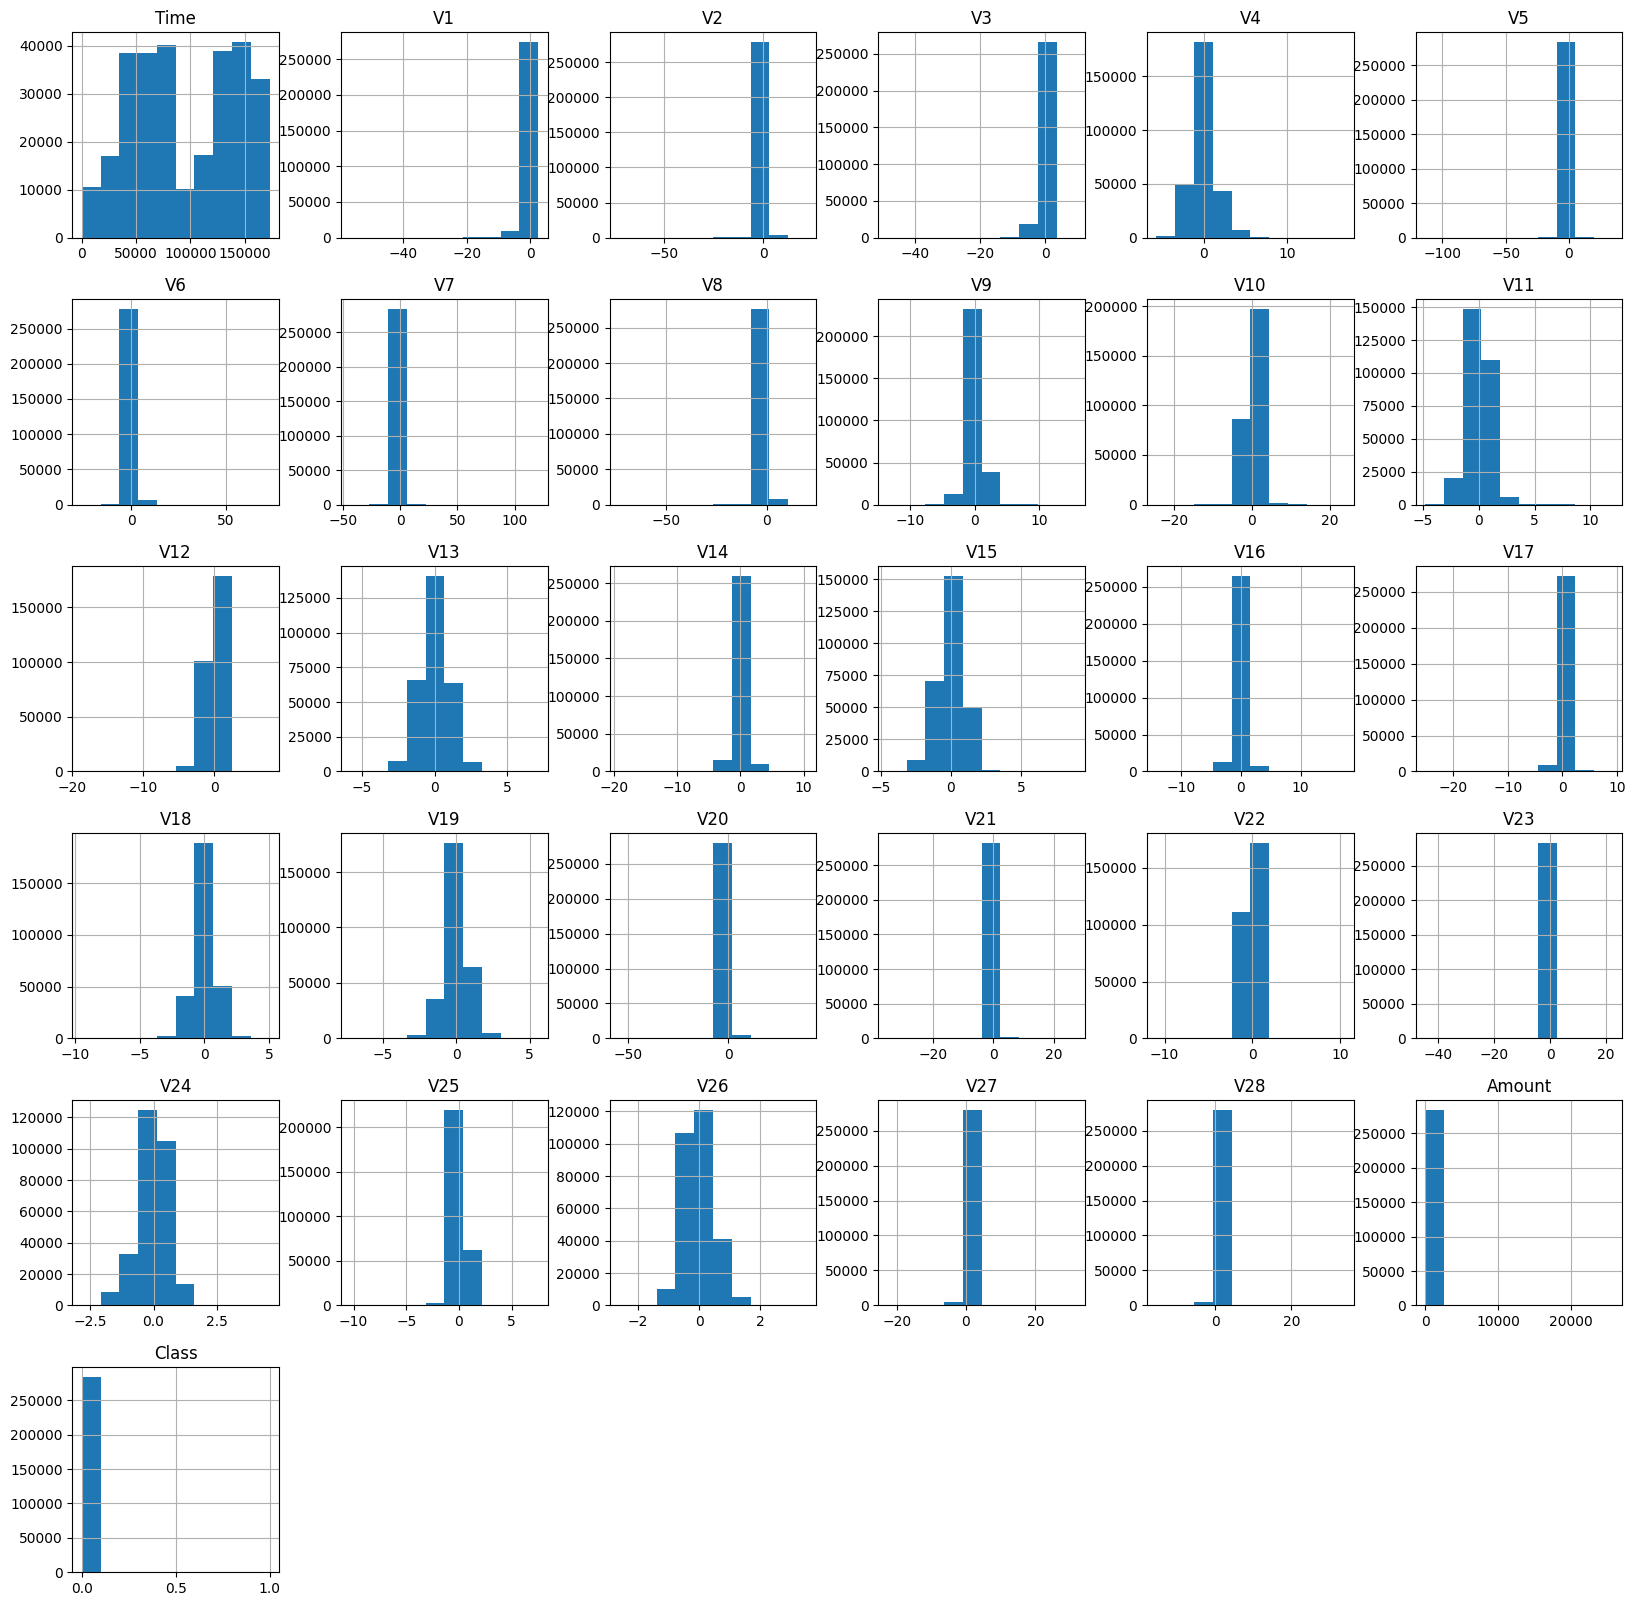

In [86]:
df.hist(figsize=(20,20));

<Axes: >

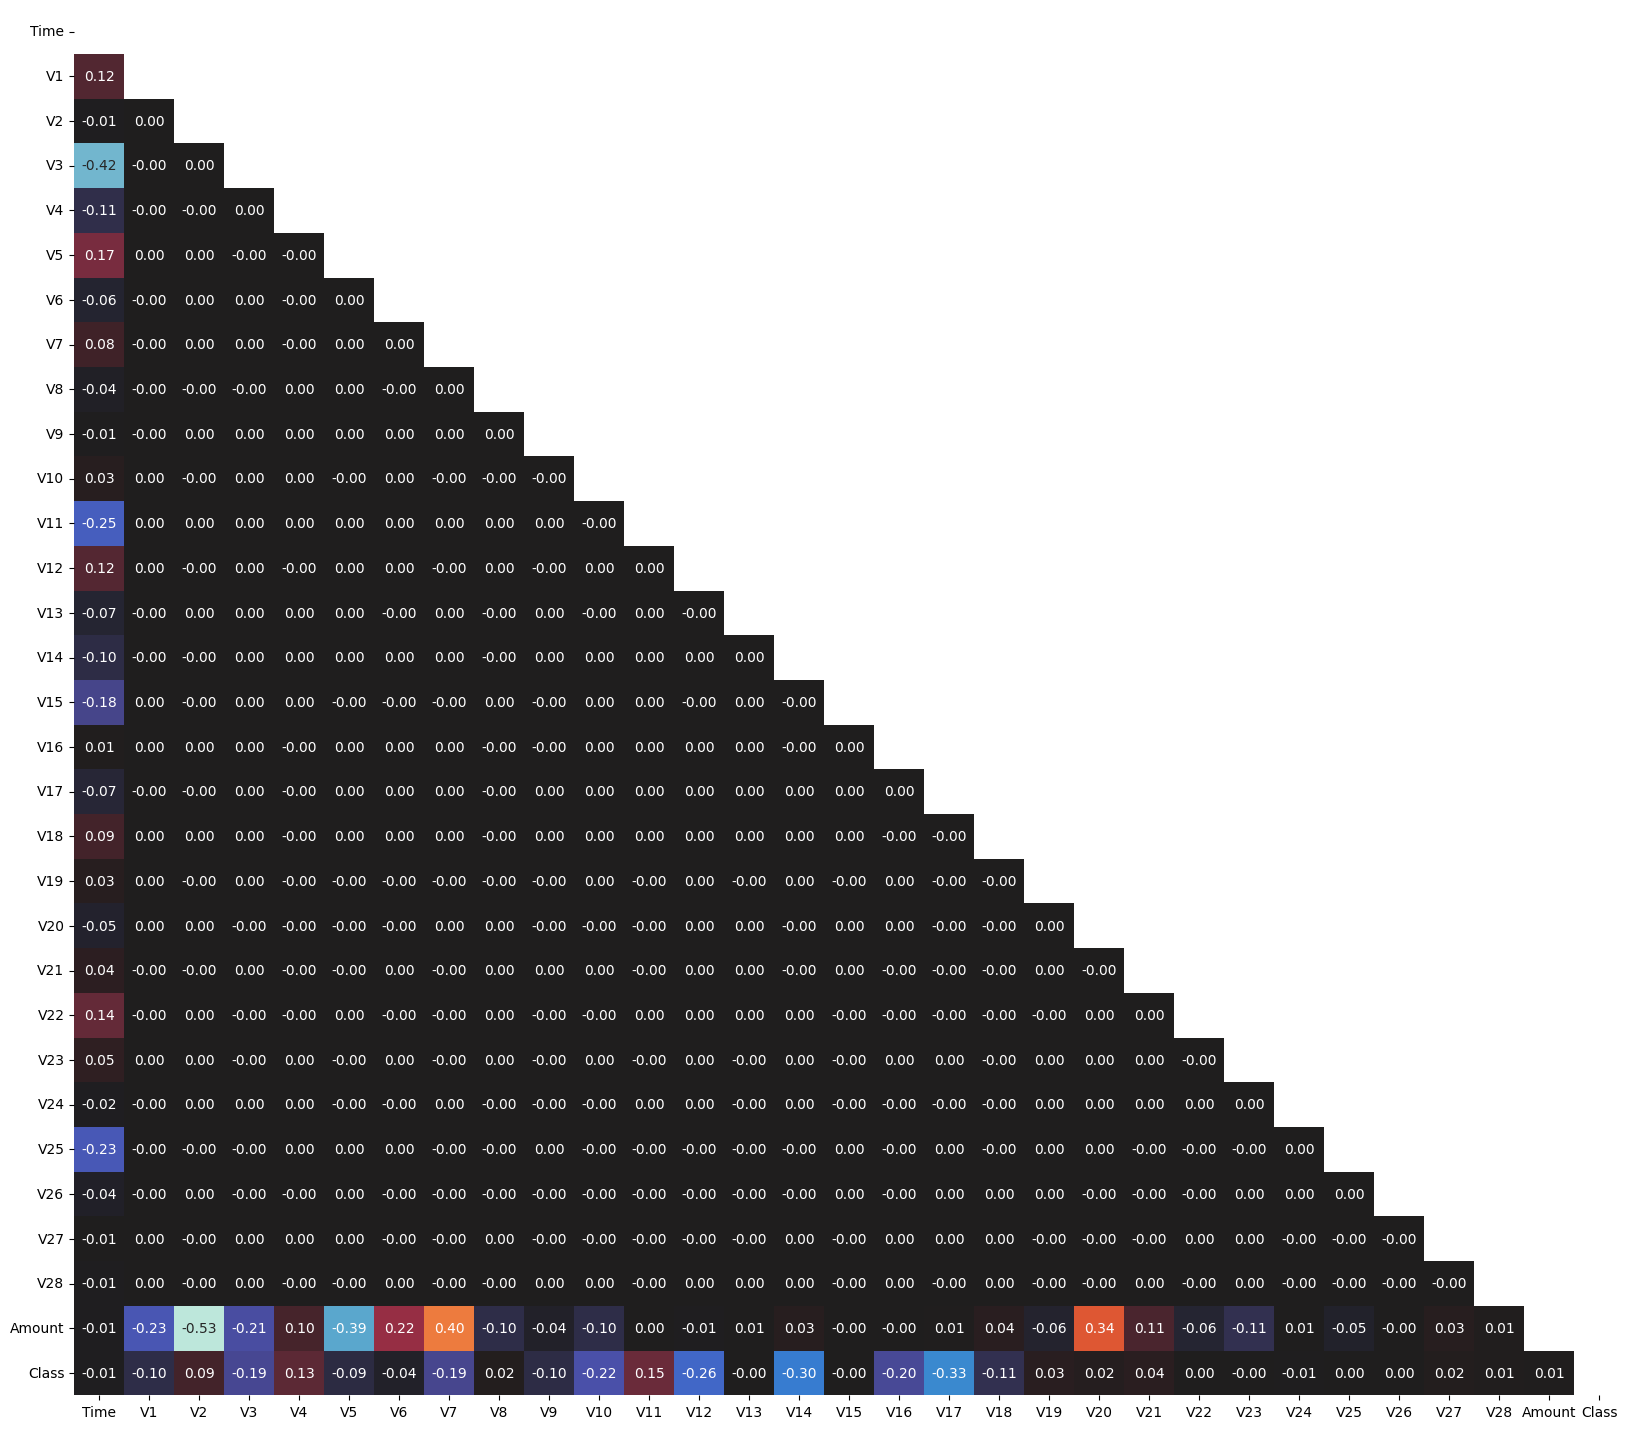

In [87]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,18))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', center=0, cbar=False)

In [88]:
high_corr = [
    column for column in corr.columns if any((corr[column] < 1) & ((corr[column] > 0.35) | (corr[column] < -0.35)))
]

In [89]:
high_corr

['Time', 'V2', 'V3', 'V5', 'V7', 'Amount']

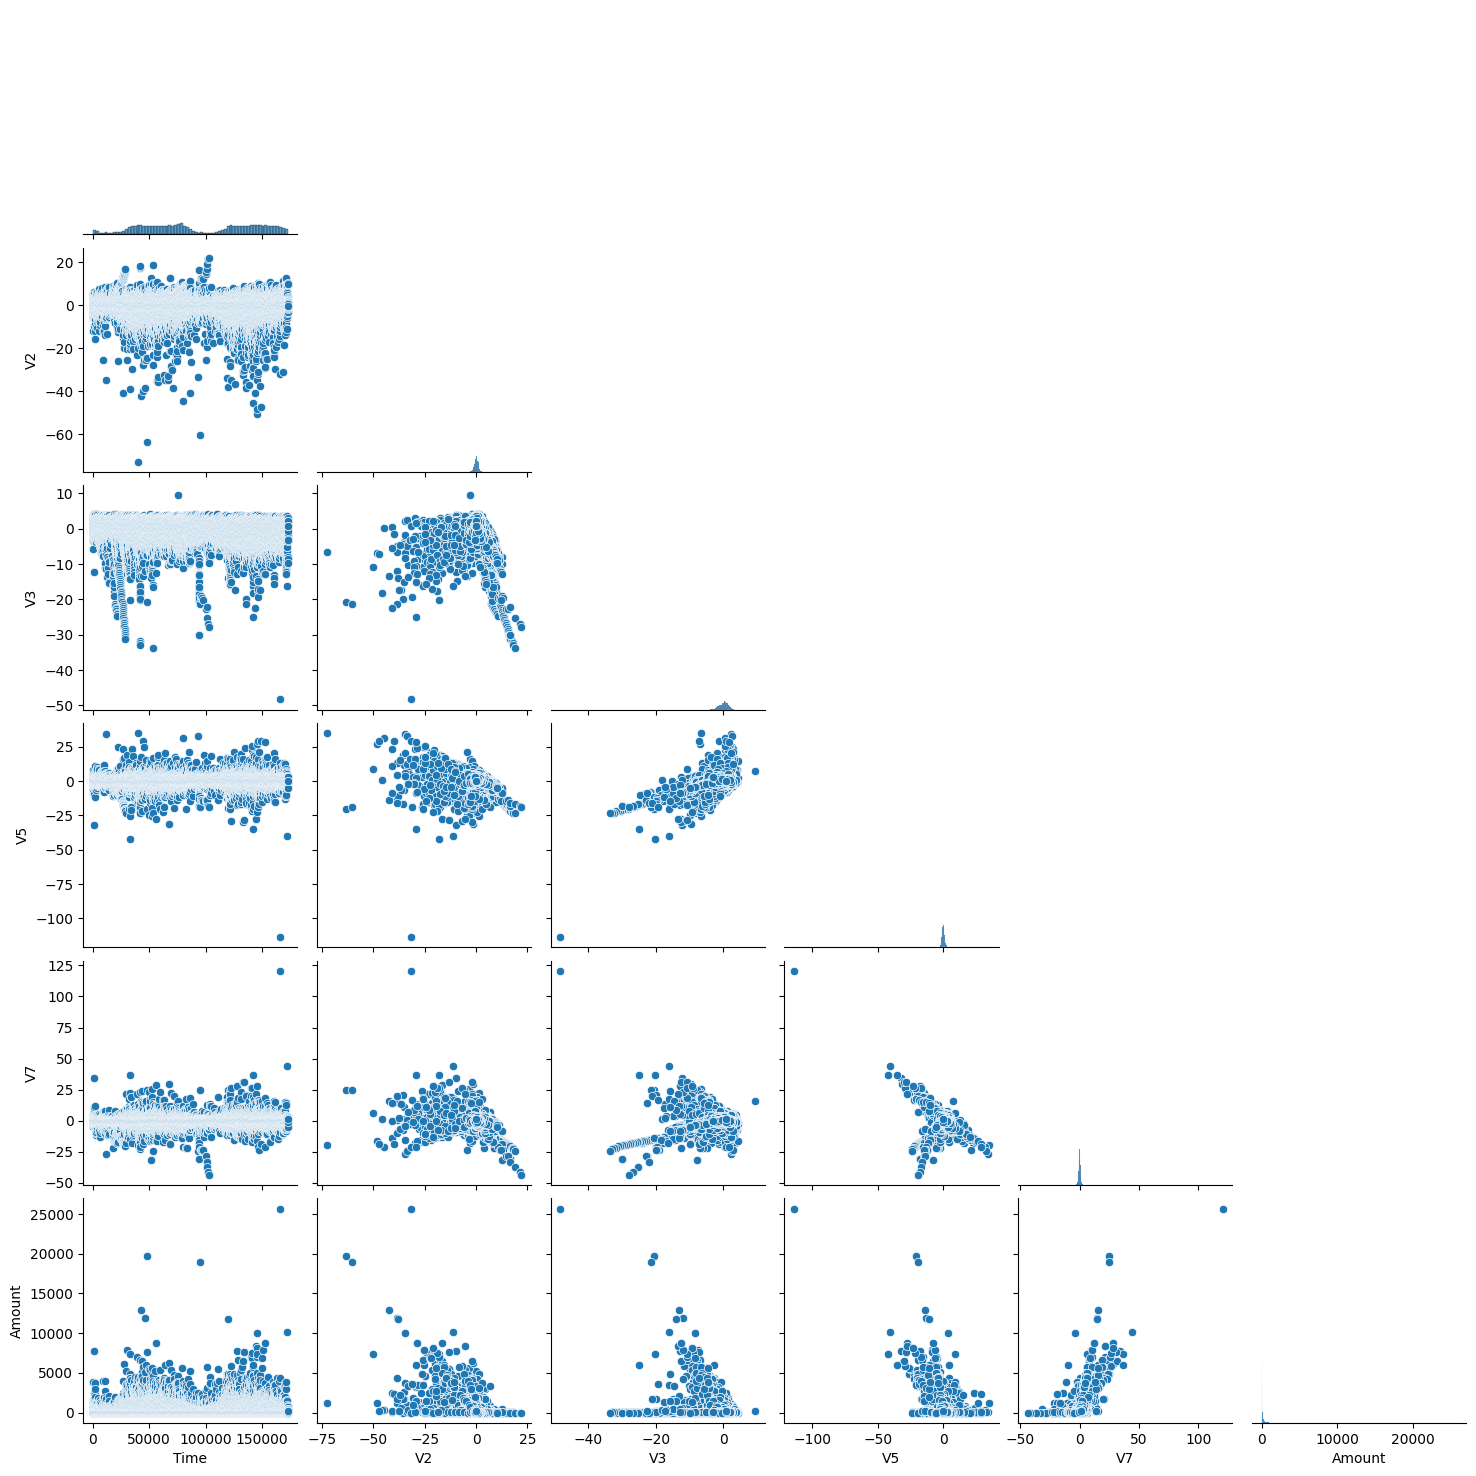

In [90]:
sns.pairplot(df[high_corr], corner=True);

Доли значений Class

In [91]:
vc = df['Class'].value_counts()
pd.DataFrame({
    'count': vc,
    'percent': (vc / len(df) * 100).round(2)
})

,count,percent
Class,,
0,284315,99.830
1,492,0.170


0.17% - это будет нашим целевым показателем для дальнейшего сравнения алгоритмов.

Для дальнейшей работы из датасета удалим целевую колонку и колонку со временем

In [92]:
PERCENT_TARGET = 0.173

In [93]:
df_cls = df.drop(columns=['Class', 'Time']).copy()
high_corr = high_corr[1:]

In [94]:
high_corr

['V2', 'V3', 'V5', 'V7', 'Amount']

## <center>Простейшие алгоритмы <a class="anchor" id="simple_models"/></center>

### 3-сигмы <a class="anchor" id="3-sigma"/>

**Идея метода**

Если данные распределены примерно нормально (колокол Гаусса), то:
* ~68% значений лежат в пределах ±1σ
* ~95% — в пределах ±2σ
* ~99.7% — в пределах ±3σ

То есть шанс, что нормальная точка окажется дальше, меньше 0.3%.
А всё, что пошло гулять за 3σ — скорее всего не норма.

Таким образом, в нашем случае применять этот метод в лоб смысла не имеет, так как он подходит только если данные - нормальные.

Чтобы выполнить задачу используем преобразование Yeo-Johnson, которое подходит к нулевым и отрицательным значениям.

In [95]:
from sklearn.preprocessing import PowerTransformer

df_norm = df_cls.copy()

# Инициализируем Yeo–Johnson
pt = PowerTransformer(method="yeo-johnson", standardize=False)
# Применяем ко ВСЕМ числовым столбцам
num_cols = df_norm.select_dtypes(include=['int64', 'float64']).columns
df_norm[num_cols] = pt.fit_transform(df_norm[num_cols])

In [96]:
df_norm.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.081,-0.072,3.312,1.263,-0.337,0.437,0.240,0.100,0.355,0.090,...,0.252,-0.018,0.280,-0.110,0.068,0.130,-0.197,0.134,-0.021,4.490
1,1.485,0.273,0.171,0.433,0.060,-0.083,-0.079,0.086,-0.260,-0.169,...,-0.069,-0.228,-0.626,0.102,-0.319,0.170,0.122,-0.009,0.015,1.268
2,-1.080,-1.211,2.183,0.369,-0.500,1.520,0.792,0.256,-1.642,0.205,...,0.527,0.245,0.790,0.934,-0.613,-0.319,-0.144,-0.055,-0.060,5.213
3,-0.809,-0.182,2.211,-0.918,-0.010,1.096,0.238,0.396,-1.496,-0.055,...,-0.208,-0.109,0.005,-0.189,-0.982,0.682,-0.233,0.063,0.061,4.337
4,-0.945,0.946,1.870,0.390,-0.405,0.095,0.593,-0.261,0.779,0.723,...,0.410,-0.009,0.818,-0.137,0.145,-0.202,0.453,0.222,0.212,3.879


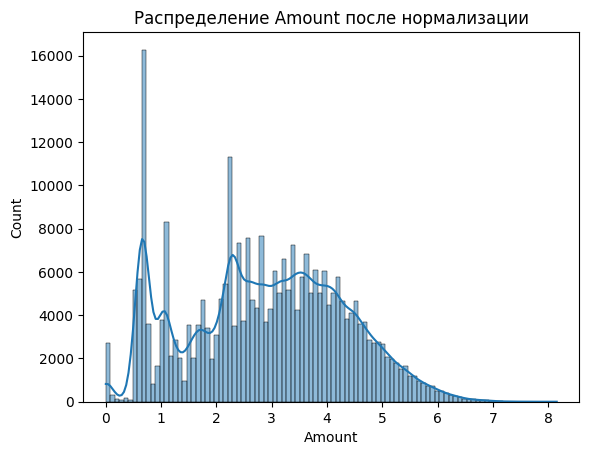

In [97]:
# Для примера посмотрим распределение признака после нормализации
sns.histplot(df_norm, x='Amount', bins=100, kde=True)
plt.title("Распределение Amount после нормализации")
plt.show()

In [98]:
# используем метод из лекции
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(axis = 1)
    return anomalies, up_bound, low_bound

In [99]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns

    outliers = pd.Series(data=[False]*len(data), index=data.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True

    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    comparison_table = comparison_table.sort_values(by='anomalies_percentage', ascending=False)

    return comparison_table, outliers

def anomalies_report(outliers, df_class):
    # percent_true = (df_class['Class'].astype(bool) & outliers).mean() * 100
    print("Total number of outliers:     ", sum(outliers))
    print("Percentage of outliers:        {:.2f}%".format(100*sum(outliers)/len(outliers)))

In [100]:
comparison_table, std_outliers = get_column_outliers(df_norm)
anomalies_report(std_outliers, df)

Total number of outliers:      31385
Percentage of outliers:        11.02%


11% - это слишком высокое значение, попробуем изменить порог на более высокое значение, просто уже ради интереса.

In [101]:
threshold = 3
th_range = range(13, 20) # значения заранее уже подобраны в ходе экспериментов
for i in tqdm(th_range):
    comparison_table, std_outliers = get_column_outliers(df_norm, threshold=i)
    if 100 * sum(std_outliers)/len(std_outliers) < 0.17:
        break
    threshold = i

threshold

 57%|█████▋    | 4/7 [00:05<00:03,  1.27s/it]


16

In [102]:
comparison_table, std_outliers = get_column_outliers(df_norm, threshold=threshold)
anomalies_report(std_outliers, df)

Total number of outliers:      548
Percentage of outliers:        0.19%


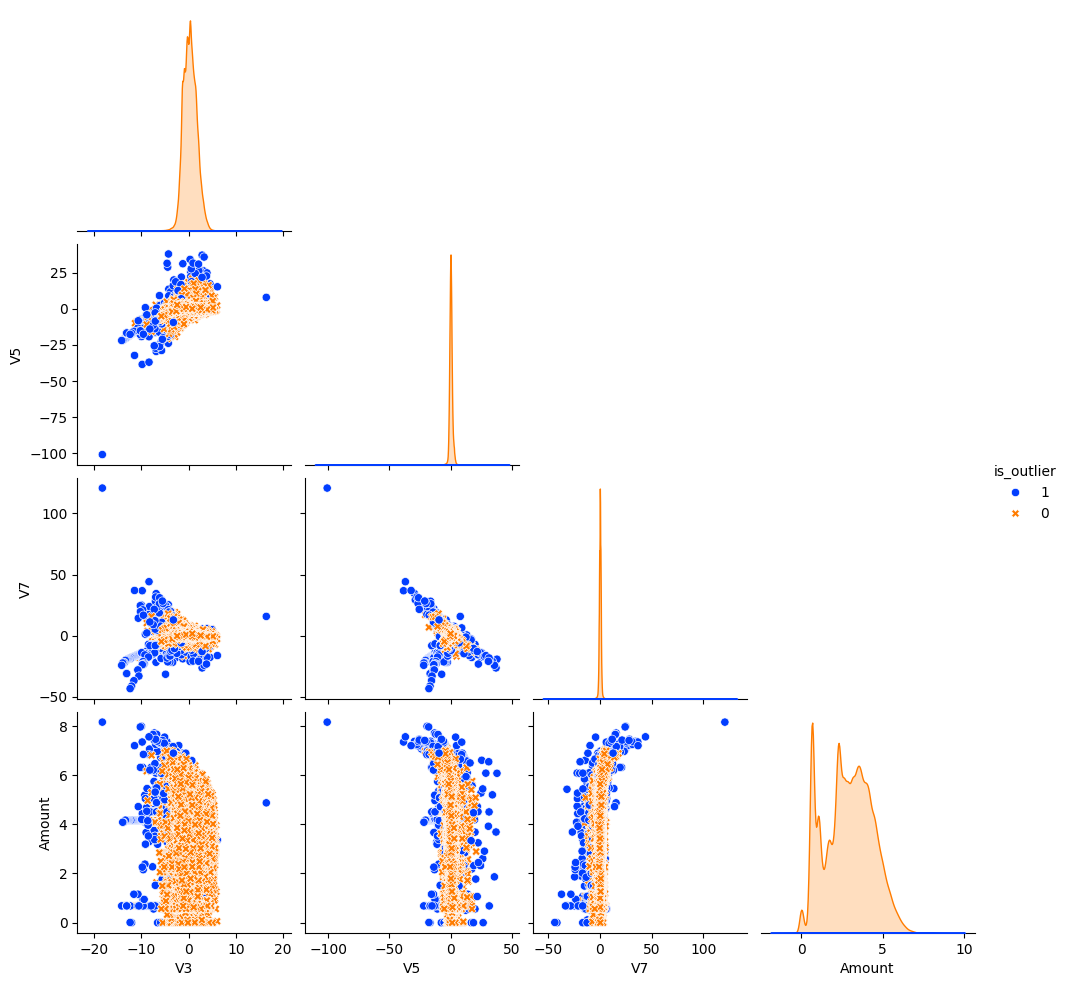

In [104]:
high_corr_norm = high_corr[1:]
labeled_data = df_norm[high_corr_norm].copy()
labeled_data['is_outlier'] = std_outliers

sns.pairplot(data=labeled_data, vars = high_corr_norm,
             hue='is_outlier', hue_order=[1,0],
             markers=['X', 'o'],  palette='bright', corner=True);

### Межквартильное отклонение <a class="anchor" id="quant"/>

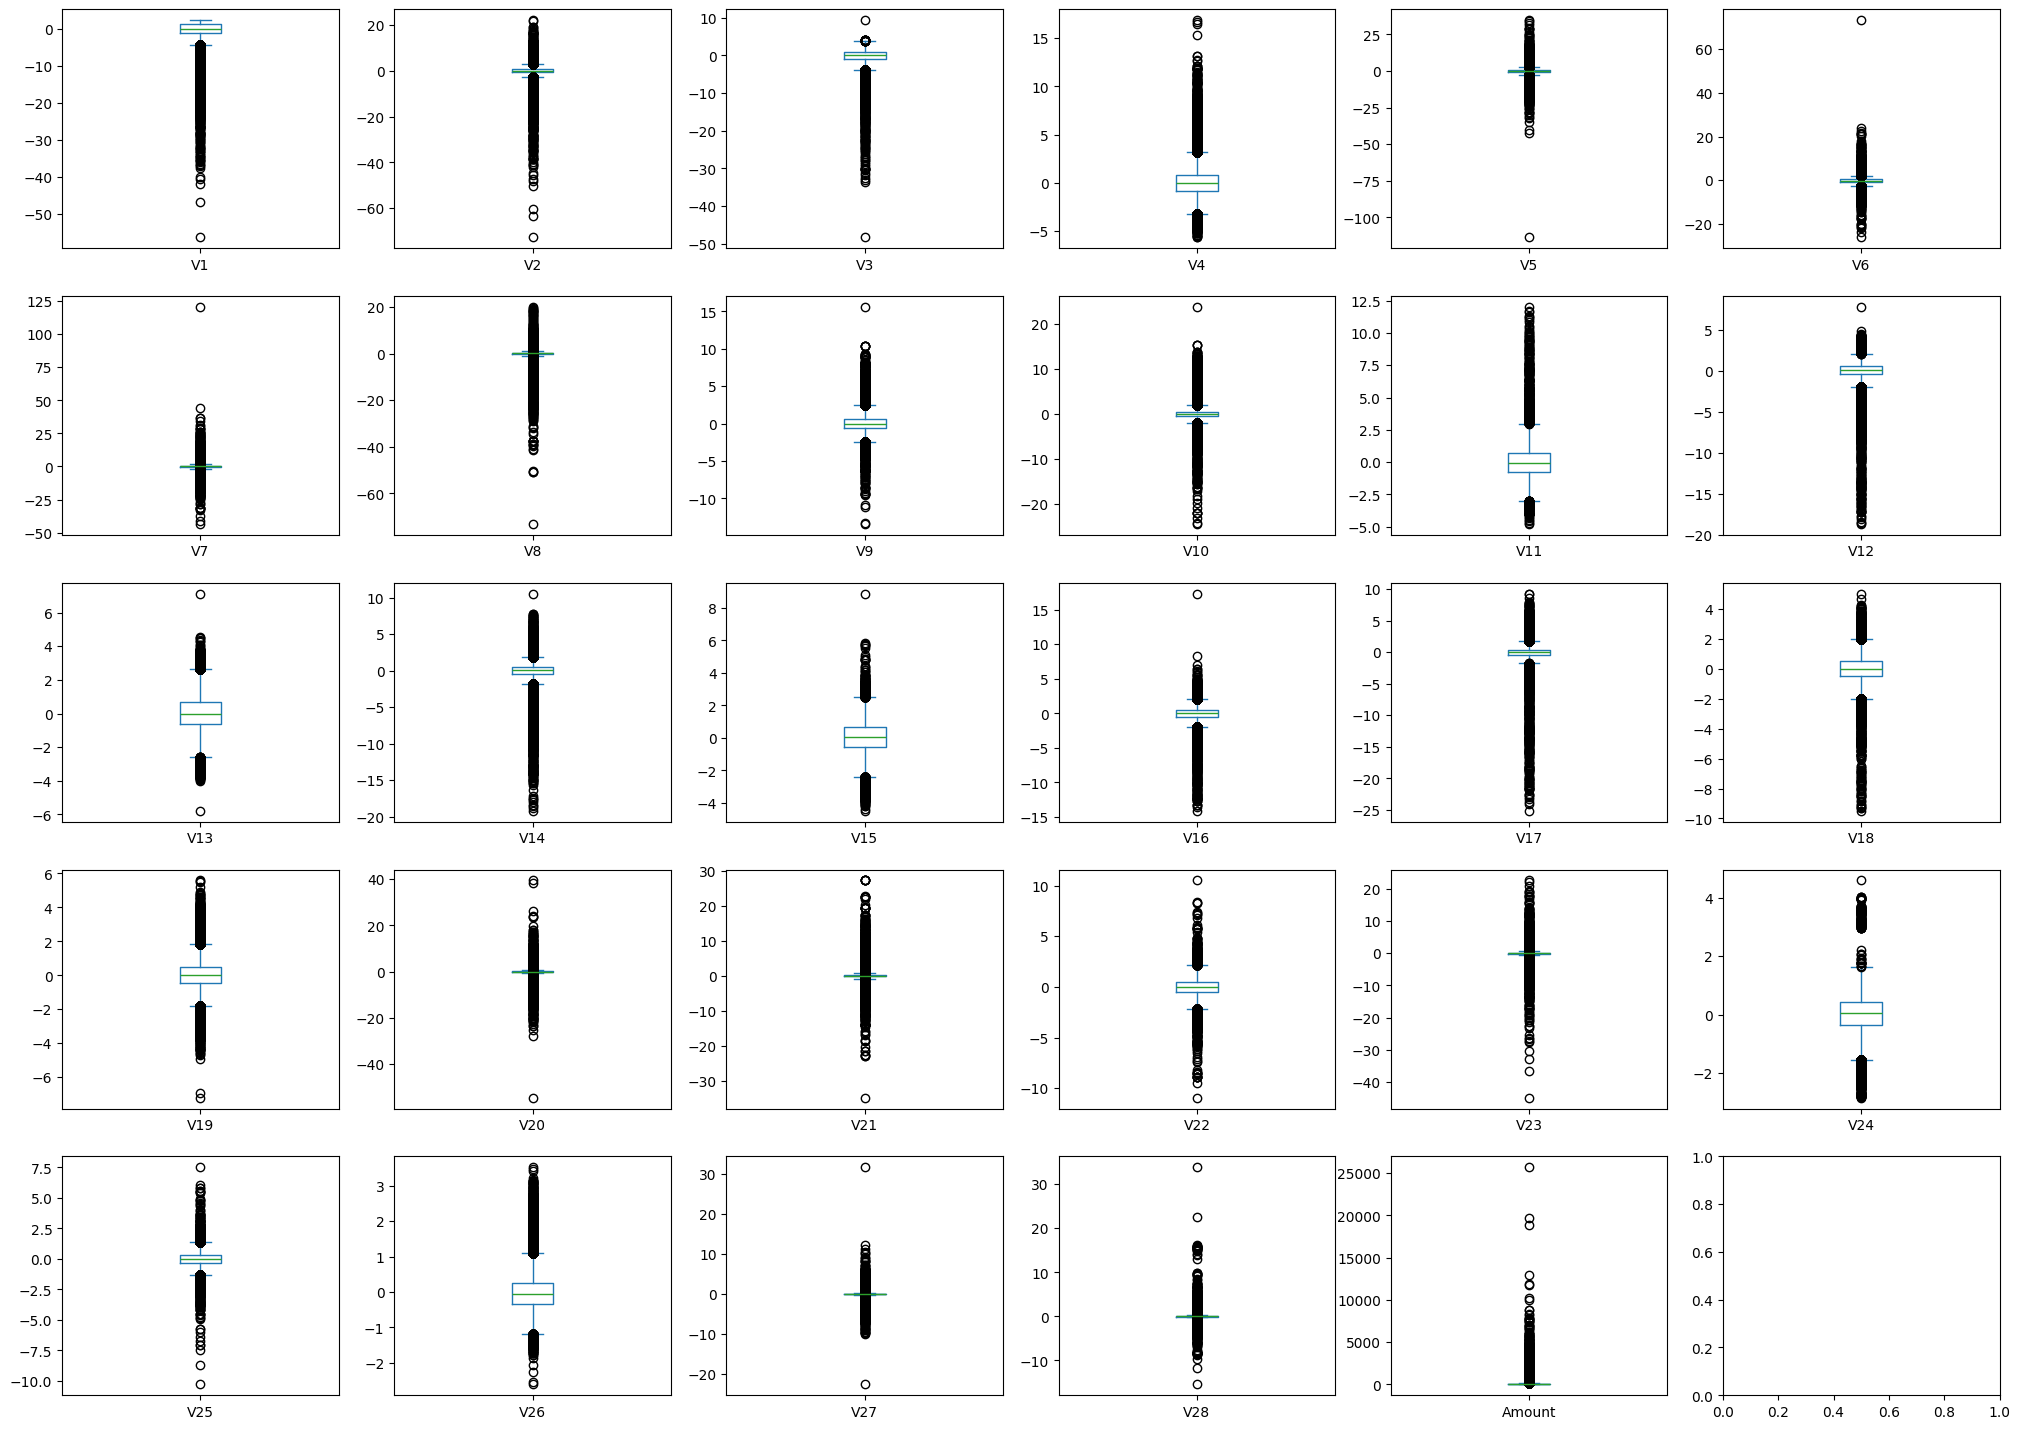

In [105]:
fig, axes = plt.subplots(5, 6, figsize=(25, 18))
# fig.suptitle('Box-plots')
row=0
col=0
for ax, feature in enumerate(df_cls):
    df_cls[feature].plot.box(ax=axes[row, col])
    col+=1
    if col > 5:
        row+=1
        col=0

In [106]:
def outlier_iqr(data, col, threshold=1.5):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    up_bound = data[col].quantile(0.75) + (IQR * threshold)
    low_bound = data[col].quantile(0.25) - (IQR * threshold)
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(axis = 1)
    return anomalies, up_bound, low_bound

In [107]:
comparison_table, iqr_outliers = get_column_outliers(df_cls, function=outlier_iqr)
anomalies_report(iqr_outliers, df)

Total number of outliers:      53336
Percentage of outliers:        18.73%


Меняем величину порога.

In [108]:
threshold = 3
th_range = range(40, 45)
for i in tqdm(th_range):
    comparison_table, iqr_outliers = get_column_outliers(df_cls, function=outlier_iqr, threshold=i)
    if 100 * sum(iqr_outliers)/len(iqr_outliers) < 0.17:
        break
    threshold = i

threshold

 60%|██████    | 3/5 [00:05<00:03,  1.76s/it]


42

In [109]:
comparison_table, iqr_outliers = get_column_outliers(df_cls, function=outlier_iqr, threshold=threshold)
anomalies_report(iqr_outliers, df)

Total number of outliers:      519
Percentage of outliers:        0.18%


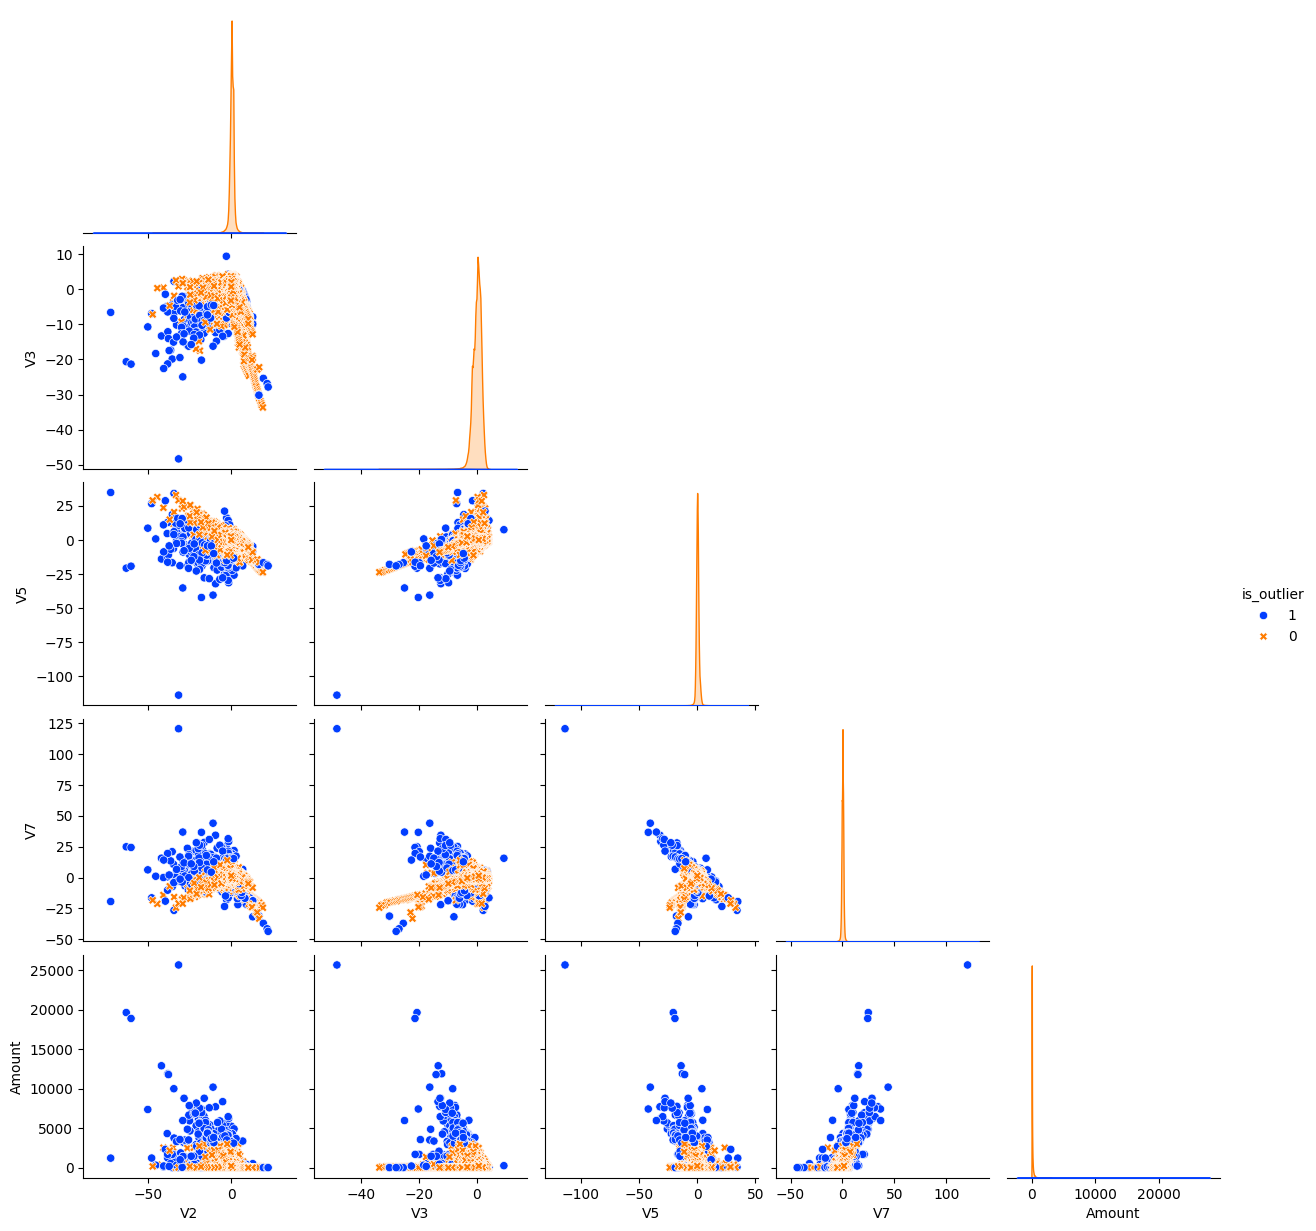

In [110]:
labeled_data = df_cls[high_corr].copy()
labeled_data['is_outlier'] = iqr_outliers

sns.pairplot(data=labeled_data, vars = high_corr,
             hue='is_outlier', hue_order=[1,0],
             markers=['X', 'o'],  palette='bright', corner=True);

## <center>Кластеризация <a class="anchor" id="cluster"/></center>

### Distance-based <a class="anchor" id="cluster_distance"/>

Для distance-based алгоритмов обязательная нормализация даных. RobustScaler наилучшим образом подходит для данных с выбросами.

In [111]:
scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(df_cls),
    columns=df_cls.columns
)

In [112]:
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist

class DistanceOutliers(BaseEstimator):
    """
    -----------
    Parameters:

    - metric: string, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)

    - percentile: float in range [0, 100]
        hyperparameter which sets the threshold for anomalies
    """
    def __init__(self, metric='euclidean', percentile: float = 90):
        self.metric = metric
        self.percentile = percentile

    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)

    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

**Возможные расстояния:**\
euclidean: $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + ... }$\
minkowski: Обобщение Евклидового расстояния\
cityblock: Manhattan $|x_1 - x_2| + |y_1 - y_2|$\
chebyshev: $max(|x_1 - x_2| + |y_1 - y_2|)$\
cosine: Меряет угол между векторами, а не длину. Отлично подходит для текста, рекомендательных систем, high-dimensional данных.\
correlation: Похож на cosine, но дополнительно центрирует данные. Хорош при анализе временных рядов.\
hamming: Процент различающихся позиций. Для булевых векторов - вообще топ.\
jaccard: Для множеств или бинарных векторов: $1 - (intersection / union)$ Используется в анализе категориальных или булевых признаков.


In [113]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=(100-PERCENT_TARGET))
euclidian_model.fit(scaled_data)
euclidian_outliers = euclidian_model.predict(scaled_data)
anomalies_report(euclidian_outliers, df)

Total number of outliers:      493
Percentage of outliers:        0.17%


Проверим модель с другими метриками

In [114]:
cityblock_model = DistanceOutliers(metric='cityblock', percentile=(100-PERCENT_TARGET))
cityblock_model.fit(scaled_data)
cityblock_outliers = cityblock_model.predict(scaled_data)
anomalies_report(cityblock_outliers, df)

Total number of outliers:      493
Percentage of outliers:        0.17%


### Density-based: DBSCAN <a class="anchor" id="cluster_dbscan"/>

In [115]:
model = DBSCAN(3.0, min_samples=5)
model.fit(scaled_data)
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])

In [116]:
anomalies_report(density_outlier, df)

Total number of outliers:      26922
Percentage of outliers:        9.45%


При сравнительно большом eps получилось более 9% выбросов.\
Увеличивая eps компьютеру не хватило ресурсов для рассчета, поэтому оценка для метода будет пропущена.

### Unsupervised model-based

### One-Class SVM <a class="anchor" id="cluster_svm"/>

Повторение из лекции.

Если совсем вкратце, SVM - базовая линейная модель. Основная идея алгоритма (в случае с классификацией) - разделить классы гиперплоскостью так, чтобы максимизировать расстояние (зазор) между ними. Изначально алгоритм был способен работать только с линейно разделимыми классами, однако в 90-е годы прошлого века метод стал особенно популярен из-за внедрения "Kernel Trick" (1992), позволившего эффективно работать с линейно неразделимыми данными.

**Kernel Trick**

Ядро (kernel) - это функция, которая способна преобразовать признаковое пространство (в том числе нелинейно), без непосредственного преобразования признаков.

Крайне эффективна в плане вычисления и потенциально позволяет получать бесконечноразмерные признаковые пространства.

Идея заключается в том, что классы, линейно неразделимые в текущем признаковом пространстве, могут стать разделимыми в пространствах более высокой размерности:

[Хорошая статья по One Class SVM](https://medium.com/@roshmitadey/anomaly-detection-using-support-vectors-2c1b842213ed)

**One Class SVM** - это одна из форм классического алгоритма, однако, как следует из названия, для его обучения нам достаточно иметь всего один класс, пусть даже и немного "зашумленный", при этом мы хотим научиться для каждого нового наблюдения принимать решение, является ли оно аномальным или нет.

**Общая идея:** преобразовать признаковое пространство и провести разделяющую гиперплоскость так, чтобы наблюдения лежали как можно дальше от начала координат:

In [117]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=0.001, gamma='auto')
one_class_svm.fit(scaled_data)
svm_outliers = one_class_svm.predict(scaled_data)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

In [118]:
anomalies_report(svm_outliers, df)

Total number of outliers:      3086
Percentage of outliers:        1.08%


In [ ]:
tsne = TSNE(perplexity=50, n_jobs=-1)
tsne_transformed = tsne.fit_transform(scaled_data)

# np.save("tsne_result.npy", tsne_transformed)
# tsne_transformed = np.load("tsne_result.npy")

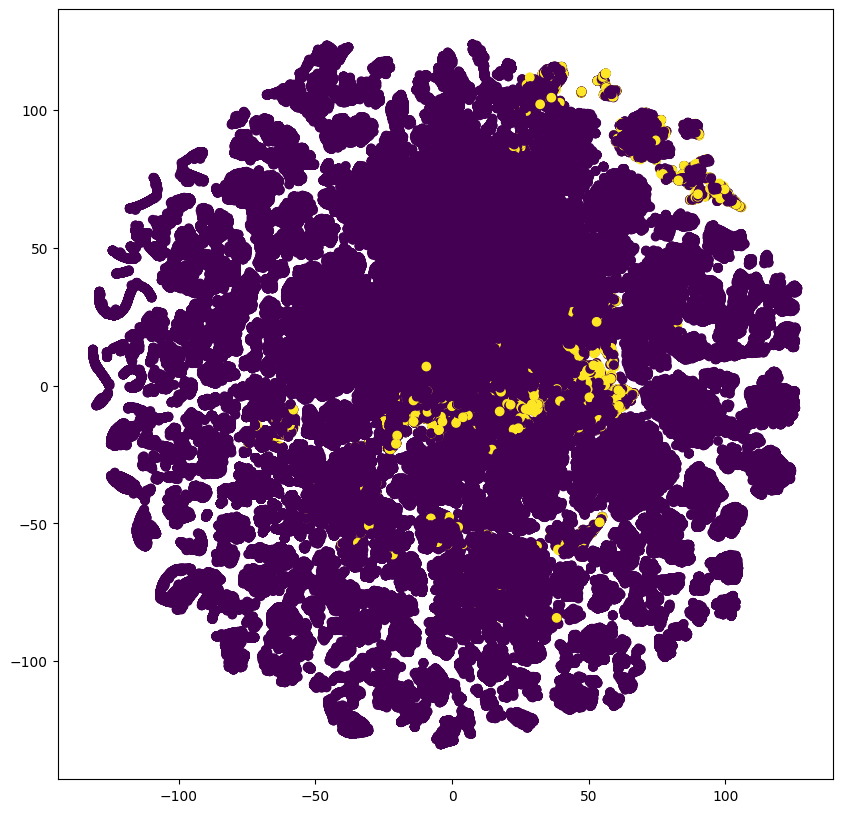

In [120]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=svm_outliers);

### Isolation Forest <a class="anchor" id="isof"/>

Идея - давайте посмотрим, насколько легко можно "изолировать" наблюдение от всех остальных. Если слишком легко, наверное она лежит далеко и является выбросом. Если очень тяжело - скорее всего она похожа на кучу других точек и выбросом не является.

In [121]:
isolation_forest = IsolationForest(
    n_estimators=300,
    contamination=PERCENT_TARGET/100, # та самая подсказка об ожидаемой доли ответов - 0.17%
    max_features=1.0,
    bootstrap=True,
    random_state=100,
    n_jobs=-1
)
isolation_forest.fit(scaled_data)

isolation_outliers = isolation_forest.predict(scaled_data)
isolation_outliers = np.where(isolation_outliers == -1, 1, 0)

In [122]:
anomalies_report(isolation_outliers, df)

Total number of outliers:      493
Percentage of outliers:        0.17%


## <center>Оценка результатов <a class="anchor" id="summary"/></center>

#### 3-сигмы

In [123]:
print(confusion_matrix(df['Class'].to_numpy(), std_outliers))

[[283866    449]
 [   393     99]]


In [124]:
print(classification_report(df['Class'].to_numpy(), std_outliers, digits=3))

              precision    recall  f1-score   support

           0      0.999     0.998     0.999    284315
           1      0.181     0.201     0.190       492

    accuracy                          0.997    284807
   macro avg      0.590     0.600     0.594    284807
weighted avg      0.997     0.997     0.997    284807



#### Межквартильное отклонение

In [125]:
print(confusion_matrix(df['Class'].to_numpy(), iqr_outliers))

[[283811    504]
 [   477     15]]


In [126]:
print(classification_report(df['Class'].to_numpy(), iqr_outliers, digits=3))

              precision    recall  f1-score   support

           0      0.998     0.998     0.998    284315
           1      0.029     0.030     0.030       492

    accuracy                          0.997    284807
   macro avg      0.514     0.514     0.514    284807
weighted avg      0.997     0.997     0.997    284807



#### Distance-based

In [127]:
print(confusion_matrix(df['Class'].to_numpy(), euclidian_outliers))

[[283840    475]
 [   474     18]]


In [128]:
print(classification_report(df['Class'].to_numpy(), euclidian_outliers, digits=3))

              precision    recall  f1-score   support

           0      0.998     0.998     0.998    284315
           1      0.037     0.037     0.037       492

    accuracy                          0.997    284807
   macro avg      0.517     0.517     0.517    284807
weighted avg      0.997     0.997     0.997    284807



In [129]:
print(confusion_matrix(df['Class'].to_numpy(), cityblock_outliers))

[[283934    381]
 [   380    112]]


In [130]:
print(classification_report(df['Class'].to_numpy(), cityblock_outliers, digits=3))

              precision    recall  f1-score   support

           0      0.999     0.999     0.999    284315
           1      0.227     0.228     0.227       492

    accuracy                          0.997    284807
   macro avg      0.613     0.613     0.613    284807
weighted avg      0.997     0.997     0.997    284807



#### One-Class SVM

In [131]:
print(confusion_matrix(df['Class'].to_numpy(), svm_outliers))

[[281384   2931]
 [   337    155]]


In [132]:
print(classification_report(df['Class'].to_numpy(), svm_outliers, digits=3))

              precision    recall  f1-score   support

           0      0.999     0.990     0.994    284315
           1      0.050     0.315     0.087       492

    accuracy                          0.989    284807
   macro avg      0.525     0.652     0.540    284807
weighted avg      0.997     0.989     0.993    284807



#### Isolation Forest

In [133]:
print(confusion_matrix(df['Class'].to_numpy(), isolation_outliers))

[[283958    357]
 [   356    136]]


In [134]:
print(classification_report(df['Class'].to_numpy(), isolation_outliers, digits=3))

              precision    recall  f1-score   support

           0      0.999     0.999     0.999    284315
           1      0.276     0.276     0.276       492

    accuracy                          0.997    284807
   macro avg      0.637     0.638     0.637    284807
weighted avg      0.997     0.997     0.997    284807



**Что означают данные цифры на примере Isolation Forest**

confusion_matrix показывает матрицу ошибок. В строках y_true, в колонках y_pred.

* TP (True Positive) = 136. Это составляет 38% от правильных ответов.
* FP (False Positive) = 357. Это ошибки 1 рода.
* FN (False Negative) = 356. Это ошибки 2 рода.
* TN (True Negative) = 283958. Правильно определены нормальные транзакции.

classification_report

* Accuracy - 0.997. Отличное значение, но совершенно бесполезное из-за дисбаланса классов.
* Precision для класса 1 (TP/(TP+FP)) - 0.276. Из всех предсказанных фродов реально только 28%.
* Recall для класса 1 (TP/(TP+FN)) - 0.276. Модель ловит примерно 27% реальных фродов.
* F1-score для класса 1 - 0.276. Баланс между точностью и полнотой.

В целом precision и recall весьма низкие.

**Итого**

По значению Recall лучше себя показал OneClassSVM, затем IsolationForest.\
При этом у IsolationForest выше Precision, а значит и лучше баланс F1.\
На третьем месте - cityblock.